AI Programming - SW Lee

# Lab 04: AlexNet for ImageNet Challenge (ILSVRC)
## Exercise: Image Classification

Load Libraries

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU') #check available gpu
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  0


Prepare Datasets

In [3]:
dataset = 'cifar10'

if dataset == 'cifar10':
    # Load the original CIFAR10 dataset
    # CIFAR10 dataset contains 50000 training images and 10000 test images of 32x32x3 pixels
    # Each image contains a small object such as bird, truck, etc...
    (ds_train, ds_test, ds_val), ds_info = tfds.load('cifar10', split=['train[:80%]', 'test', 'train[80%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
elif dataset == 'imagenette':
    # Imagenette is a subset of 10 easily classified classes from Imagenet
    # (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
    (ds_train, ds_test, ds_val), ds_info = tfds.load('imagenette/320px-v2', split=['train', 'validation[:50%]', 'validation[50%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
else:
    print('Dataset Error')

print(ds_info.features)
print(ds_info.splits)
print(ds_info.splits['train'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: 

In [3]:
n_channels = ds_info.features['image'].shape[-1] # check channel

if dataset == 'imagenette':
    classes = ['tench', 'English springer', 'cassette player', 'chain saw',
               'church', 'French horn', 'garbage truck', 'gas pump',
               'golf ball', 'parachute']
else:
    classes = ds_info.features['label'].names
n_classes = ds_info.features['label'].num_classes # check data class

n_train = len(ds_train)
n_test = len(ds_test)
n_val = len(ds_val)

print(n_train,n_test,n_val)

9469 1962 1963


Show a Sample Data

Image demension: (320, 480, 3) , label: 1


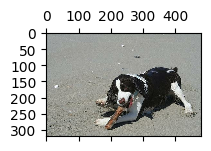

The picture is English springer


In [4]:
idx = np.random.randint(n_train-1) #create random value
#skip as random value and take one data sample
for element in ds_train.skip(idx).take(1):
    image, label = element

print('Image demension:', image.shape, ', label:',label.numpy())

dimage = tf.reshape(image, image.shape)
plt.figure(figsize=(2,2))
plt.matshow(dimage, 1)
plt.show()
print('The picture is', classes[label])

Building Input Data Pipelines

In [5]:
def tfds_4_NET(image, label):

    image = tf.image.resize((image / 255), [227,227], method='bilinear') #normalization pixel value and resize for AlexNet
    label = tf.one_hot(label, n_classes) #onehot encoding

    return image, label

In [6]:
n_batch = 64
#apply data to function
dataset = ds_train.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

valiset = ds_val.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
valiset = valiset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

testset = ds_test.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
testset = testset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

### Network Definition of AlexNet with Keras Sequential API



In [7]:
# model
AlexNet = keras.Sequential([
    ### START CODE HERE ###
    # Input Layer
    keras.layers.InputLayer(shape=(227,227,3)), #RGB 227 x 227 images

    # Layer 1
    keras.layers.Conv2D(filters=96,kernel_size=(11,11),strides=4,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((3,3),strides=2),

    # Layer 2
    keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=1,padding='same',activation='relu'), #The input image size and the output image size are the same.
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((3,3),strides=2),

    # Layer 3 to 5
    keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=1,padding='same',activation='relu'),
    keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=1,padding='same',activation='relu'),
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=1,padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((3,3),strides=2),
    keras.layers.Flatten(),
    # Layer 6 to 8
    keras.layers.Dense(units=4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10,activation='softmax') #use softmax for classification in last layer

    ### END CODE HERE ###
])

AlexNet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,324,746 (222.49 MB)

 Trainable params: 58,323,530 (222.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

**Expected Outputs**

```
┏--------------------------------------┳-----------------------------┳-----------------┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡--------------------------------------╇-----------------------------╇-----------------┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization_2                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└--------------------------------------┴-----------------------------┴-----------------┘
 Total params: 58,324,746 (222.49 MB)
 Trainable params: 58,323,530 (222.49 MB)
 Non-trainable params: 1,216 (4.75 KB)
 ```

### Training the Model

In [8]:
opt = keras.optimizers.Adam(learning_rate=0.001)
AlexNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'], jit_compile=True)
#convert model to machine code with jit_compile option

In [9]:
n_epochs = 10

results = AlexNet.fit(dataset, epochs=n_epochs, batch_size=n_batch,
                   validation_data=valiset, validation_batch_size=n_batch,
                   verbose=1)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 63s 269ms/step - acc: 0.1940 - loss: 9.5704 - val_acc: 0.2751 - val_loss: 2.0504
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 49s 143ms/step - acc: 0.2760 - loss: 2.0711 - val_acc: 0.3439 - val_loss: 1.9081
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - acc: 0.3134 - loss: 1.9753 - val_acc: 0.3260 - val_loss: 1.9401
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - acc: 0.3479 - loss: 1.9271 - val_acc: 0.3235 - val_loss: 1.9505
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 43s 158ms/step - acc: 0.3697 - loss: 1.8483 - val_acc: 0.3561 - val_loss: 1.8924
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - acc: 0.4146 - loss: 1.7523 - val_acc: 0.4269 - val_loss: 1.7688
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - acc: 0.4633 - loss: 1.6229 - val_acc: 0.3861 - val_loss: 1.7966
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - acc: 0.4904 - loss: 1.5460 - val_acc: 0.3805 - val_loss: 1.8456
Epoch 9/10
148/148 ━━━━━━━━━━━━━

Plot Convergence Graph

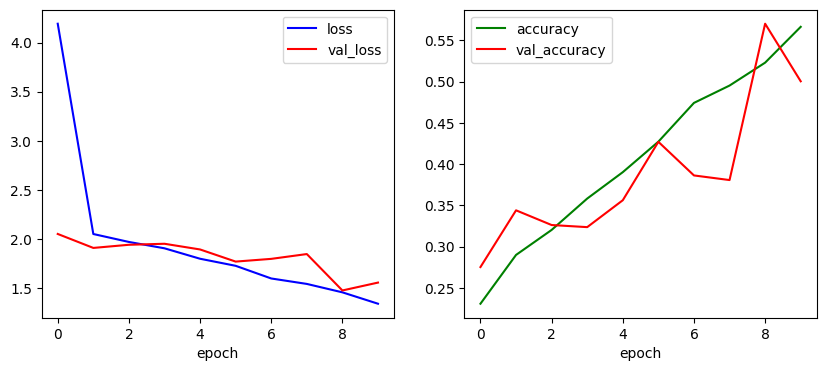

In [10]:
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.plot(results.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['acc'], 'g-', label='accuracy')
plt.plot(results.history['val_acc'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

Evaluate Model Performance

In [11]:
AlexNet.evaluate(testset)

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - acc: 0.5161 - loss: 1.5521


[1.5627949237823486, 0.5061162114143372]

### Test Model with a Random Sample


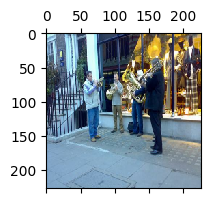

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
My prediction is chain saw
Actual image is  French horn


In [12]:
idx = np.random.randint(n_test-1)
#choice 1 random sample
for element in ds_test.skip(idx).take(1):
    img, lbl = element
    X_test, y_test = tfds_4_NET(img, lbl)

X_test = tf.expand_dims(X_test, axis=0)

dimage = np.array(X_test[0])
plt.figure(figsize=(2,2))
plt.matshow(dimage, fignum=1)
plt.show()

outt_4 = AlexNet.predict(X_test)
p_pred = np.argmax(outt_4, axis=-1)

print('My prediction is ' + classes[p_pred[0]])
print('Actual image is  ' + classes[tf.argmax(y_test, -1)])

(c) 2024 SW Lee